In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import os
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import math
import pandas as pd
import skrf as rf

2025-07-23 14:22:26.449692: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753298546.470559 3371803 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753298546.477474 3371803 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-23 14:22:26.500155: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data Loading

In [3]:
#define the targeted max frequency
fmax = 200
fstart = 0

#data loading function for images and tabular- derived from CNN path, same function used for MLP
#define function for loading images and s-parameters
#"path" is the path for images of transformer layout
#"label" is the path for labels. In this case, labels are S-parameter associated with each images 
def load_images_from_path(path, label,length):
    images = []
    labels = []
    error = []
    for kk in range(length):
        #load images
        img = image.load_img(path+str(kk)+'.png', target_size=(300, 300, 3))
        images.append(image.img_to_array(img)[38:262,38:262,:])#trim the ground margin

        #load S-parameters
        #According to symmerty, only S11,S12,S13,S14,S33,S34 are considered
        #Each S-parameter has real and imaginary parts, and hence 12 real values in total.
        results = []
        datafile = label+str(kk)+".s4p"
        spt = rf.Network(datafile)
        step = int(1e9/(spt.f[1]-spt.f[0]))
        for k in range(fmax+1):
            i = int((k+fstart)*step/2)
            results.append([spt.s[i][0][0].real,spt.s[i][0][0].imag,
                            spt.s[i][0][1].real,spt.s[i][0][1].imag,
                            spt.s[i][0][2].real,spt.s[i][0][2].imag,
                            spt.s[i][0][3].real,spt.s[i][0][3].imag,
                            spt.s[i][2][2].real,spt.s[i][2][2].imag,
                            spt.s[i][2][3].real,spt.s[i][2][3].imag])     
        labels.append(results)
        sp = np.array(results)
        invalid = False
        '''
        for k in range(len(sp)-3):
            for x in range(6):
                if (np.square(sp[k][2*x])+np.square(sp[k][2*x+1]))>1.02:
                    invalid = True
                
            for x in range(12):
                if abs(sp[k][x]+sp[k+2][x]-2*sp[k+1][x])>0.03:
                    invalid = True
                    '''
        if (invalid):
            error.append(kk)
    return images, labels,error

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)

In [4]:
#import tensorflow_datasets as tfds
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]

In [5]:
import skrf as rf
from scipy.spatial import distance
from scipy.linalg import eigh

#Snippet from indices loading from GT model
#define function for loading ind and s-parameters
#"path" is the path for ind of transformer layout
#"label" is the path for labels. In this case, labels are S-parameter associated with each ind 
def load_ind_from_path(path, label,length):
    ind_a = []
    ind_b = []
    labels = [] #could be redundant
    error = []
    for kk in range(length):
        #load ind
        ind = np.load(path+str(kk)+'.npz')
        result_a = []
        result_b = []
        dst_a = np.zeros(len(ind['a'])-1)
        aj_a = np.zeros((len(ind['a']),len(ind['a'])))
        dst_b = np.zeros(len(ind['b'])-1)
        aj_b = np.zeros((len(ind['b']),len(ind['b'])))
        
        for x in range(len(ind['a'])-1):
            dst = distance.euclidean(ind['a'][x],ind['a'][x+1])
            dst_a[x] = dst
            aj_a[x][x+1] = dst_a[x]
            aj_a[x+1][x] = dst_a[x]
        
        eigenvalues, eigenvectors = eigh(aj_a)
        
        for x in range(int(np.ceil(len(ind['a'])/2))):
            result_a.append([ind['a'][x][0]/100,ind['a'][x][1]/100,ind['a'][x+1][0]/100,ind['a'][x+1][1]/100,dst_a[x]/100,0,np.sum(eigenvectors[x][1]+eigenvectors[x+1][1])])
        ind_a.append(result_a)
        
        for x in range(len(ind['b'])-1):
            dst = distance.euclidean(ind['b'][x],ind['b'][x+1])
            dst_b[x] = dst
            aj_b[x][x+1] = dst_b[x]
            aj_b[x+1][x] = dst_b[x]
        
        eigenvalues, eigenvectors = eigh(aj_b)
        
        for x in range(int(np.ceil(len(ind['b'])/2))):
            result_b.append([ind['b'][x][0]/100,ind['b'][x][1]/100,ind['b'][x+1][0]/100,ind['b'][x+1][1]/100,dst_b[x]/100,0,np.sum(eigenvectors[x][1]+eigenvectors[x+1][1])])
        ind_b.append(result_b)
        #load S-parameters
        #According to symmerty, only S11,S12,S13,S14,S33,S34 are considered
        #Each S-parameter has real and imaginary parts, and hence 12 real values in total.
        results = []
        datafile = label+str(kk)+".s4p"
        spt = rf.Network(datafile)
        step = int(1e9/(spt.f[1]-spt.f[0]))
        for k in range(fmax+1):
            i = int(k*step/2)
            results.append([spt.s[i][0][0].real,spt.s[i][0][0].imag,
                            spt.s[i][0][1].real,spt.s[i][0][1].imag,
                            spt.s[i][0][2].real,spt.s[i][0][2].imag,
                            spt.s[i][0][3].real,spt.s[i][0][3].imag,
                            spt.s[i][2][2].real,spt.s[i][2][2].imag,
                            spt.s[i][2][3].real,spt.s[i][2][3].imag])     
        sp = np.array(results)
        invalid = False
        '''
        for k in range(len(sp)-3):
            for x in range(12):
                if abs(sp[k][x]+sp[k+2][x]-2*sp[k+1][x])>0.03:
                    invalid = True
                    '''
        if (invalid):
            error.append(kk)
        labels.append(results) #redundant from the cnn/mlp collection
    return ind_a,ind_b

In [6]:
def load_from_path(path):
    logfile = open(path+"log.txt","r")
    listall = list(map(lambda item: list(map(lambda jtem: eval(jtem.strip()), item[1:-1].split(','))), logfile.read().strip().split('\n')))
    tabular_data = np.array(listall)

#load images and s-parameters
    length = len(tabular_data)
    images, labels,error = load_images_from_path(path+"PNG/", path+"SPData/",length) #cnn, mlp data load
    ind_a, ind_b = load_ind_from_path(path+"SEG/", path+"SPData/",length) #GT data load

    
    show_images(images)
    srf = np.load(path+"/srf.npy")

    for kk in range(length):
    #select 1 turn and 1 turn transformers
        if kk in error:
            continue   
        if((tabular_data[kk,4]!=0) and (tabular_data[kk,5]!=0)):
       #geoparas only includes the variable parameters in our designs. 
       #Constants at this design stages are excluded 
            temp = next((item for item in reversed(tabular_data) if item[19] == kk), None)
            geoparas.append(np.array(temp)[[0,1,2,3,4,5,6,7,8,9,10,11,14,15,16,17]])
            images11.append(images[kk])
            labels11.append(labels[kk])
            srf_list.append(srf[kk])
        if((tabular_data[kk,2]!=0) or (tabular_data[kk,3]!=0)):
       #b only includes the variable parameters in our designs. 
       #Constants at this design stages are excluded
            for i in range(len(ind_a[kk])):
                ind_a[kk][i][5] = tabular_data[kk][6]
            for i in range(len(ind_b[kk])):
                ind_b[kk][i][5] = tabular_data[kk][7]
            ind_a11.append(np.array(ind_a[kk]))
            ind_b11.append(np.array(ind_b[kk])) #potential cause of issue if comes up in future - different label lists for graph and cnn
            

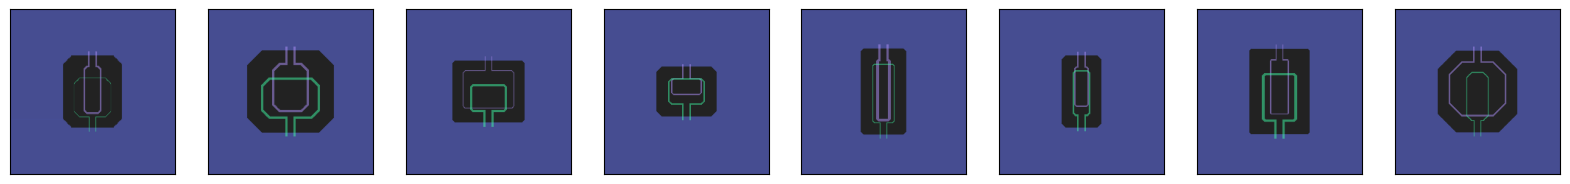

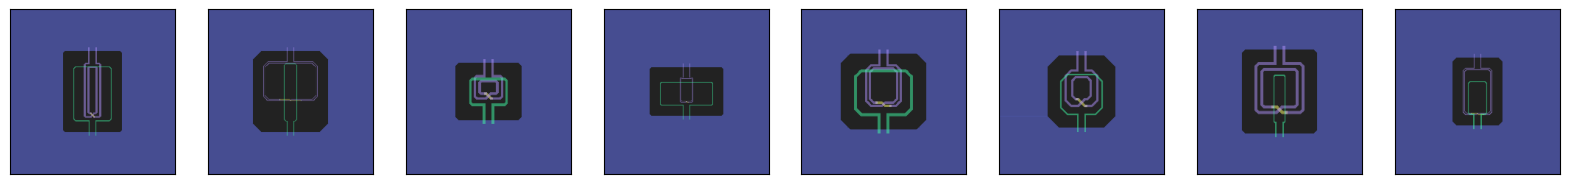

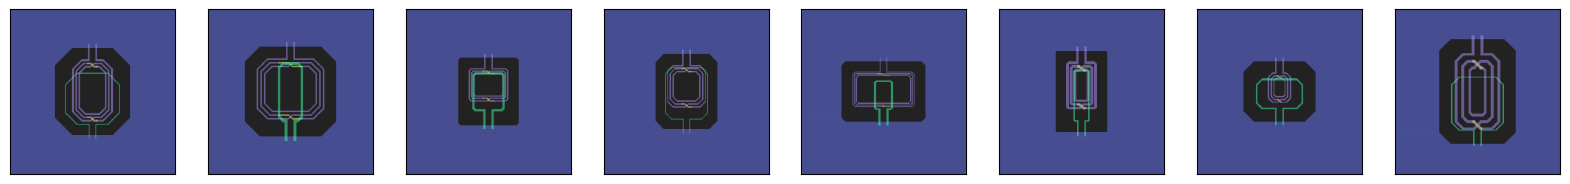

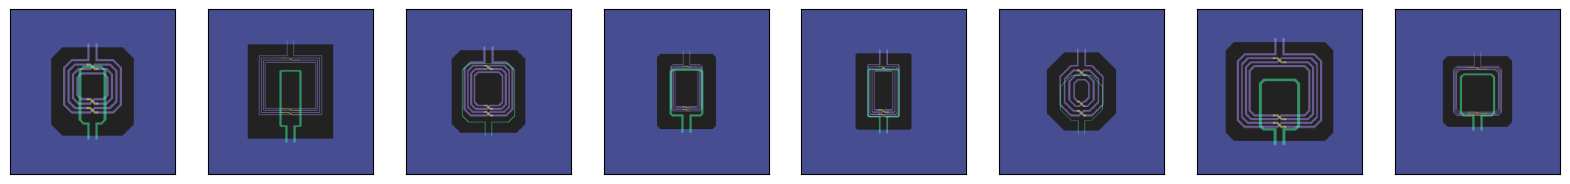

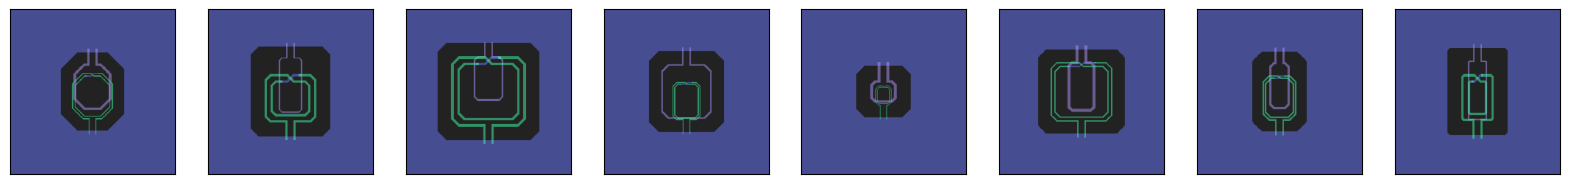

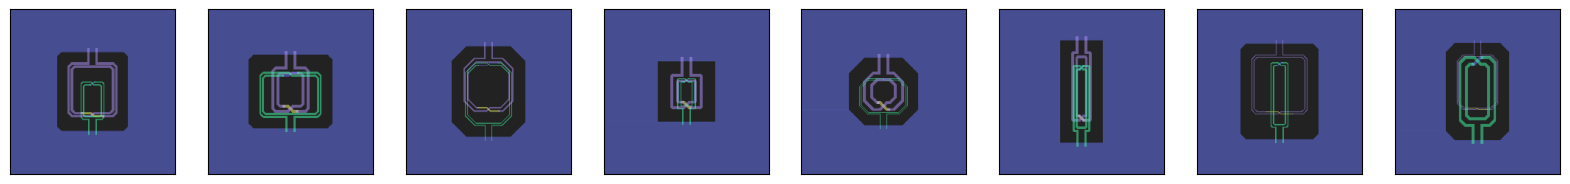

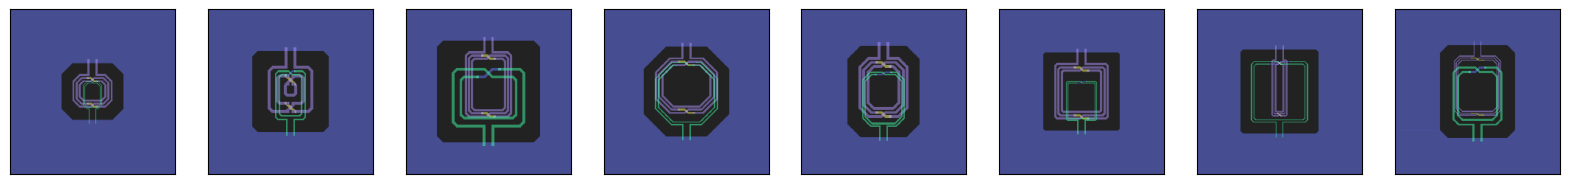

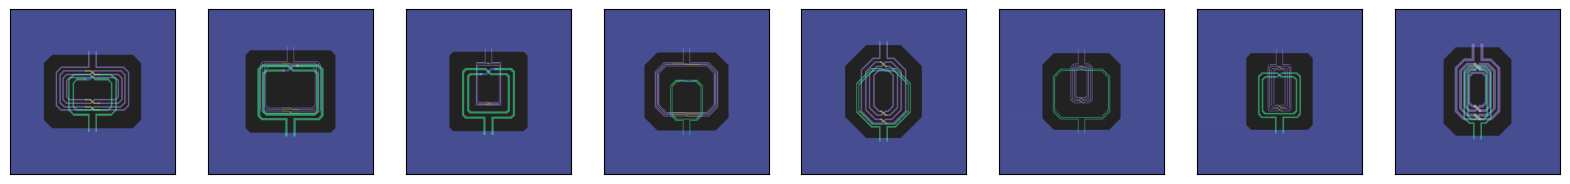

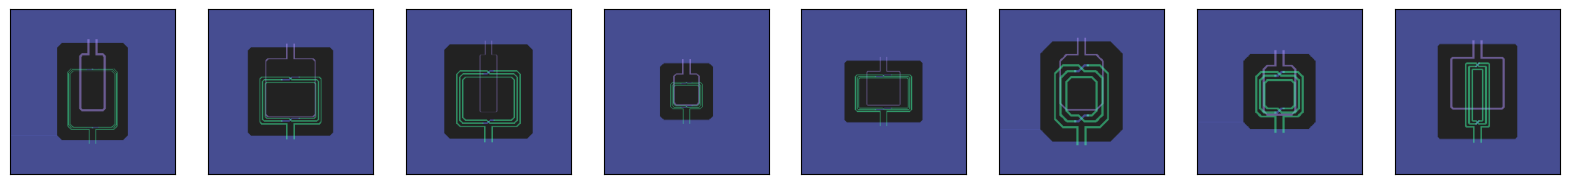

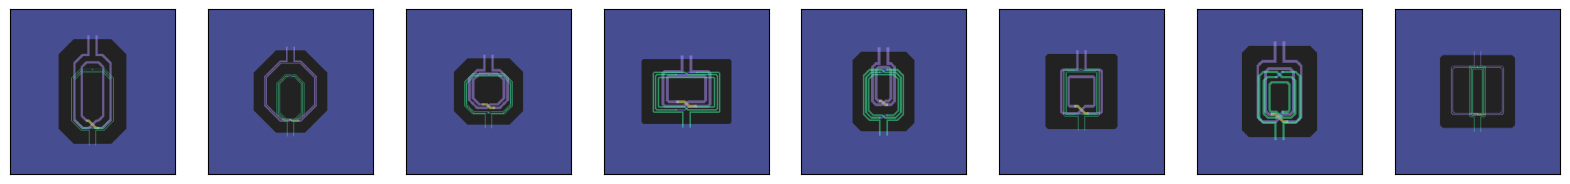

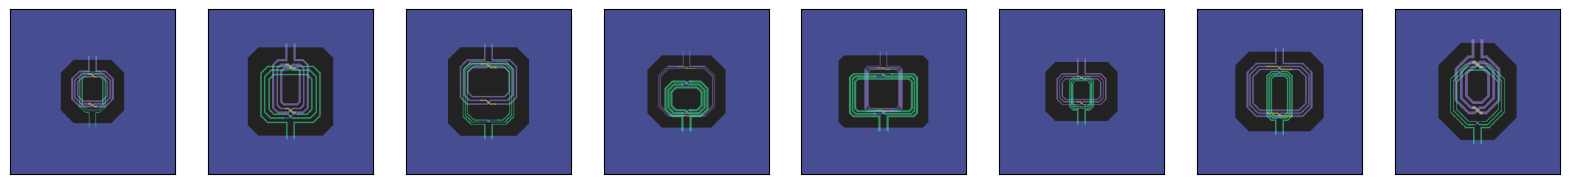

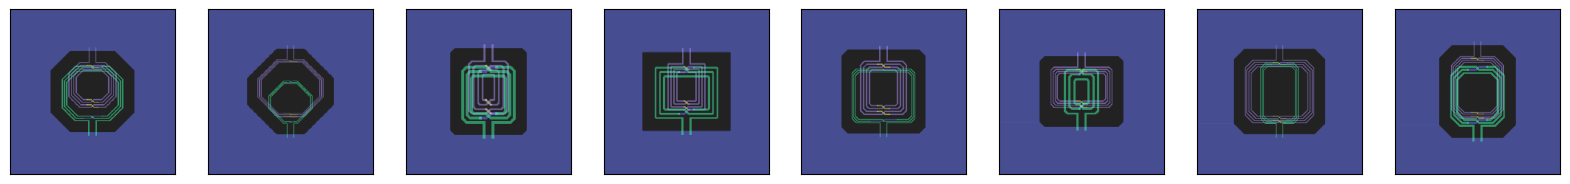

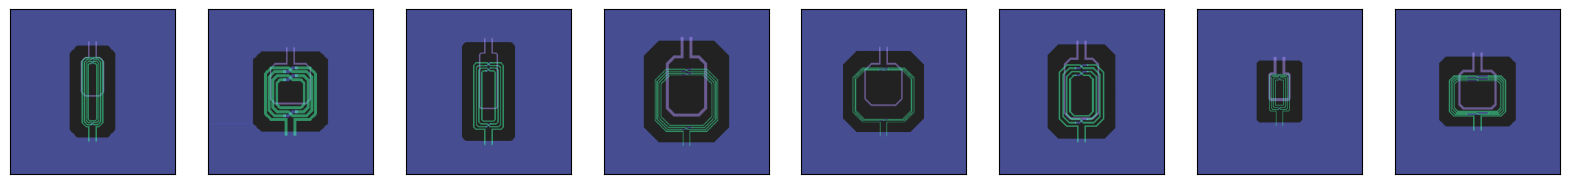

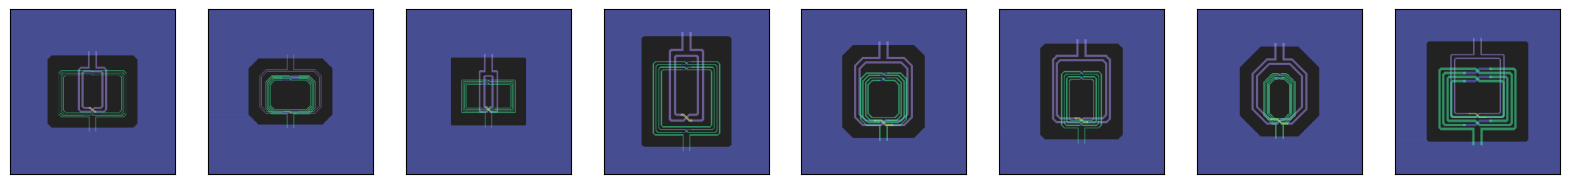

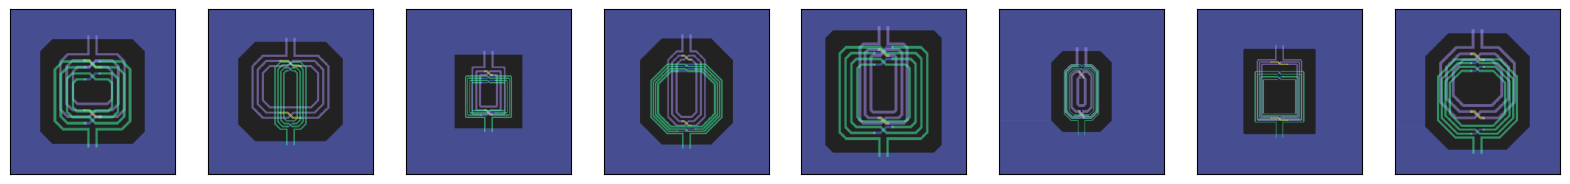

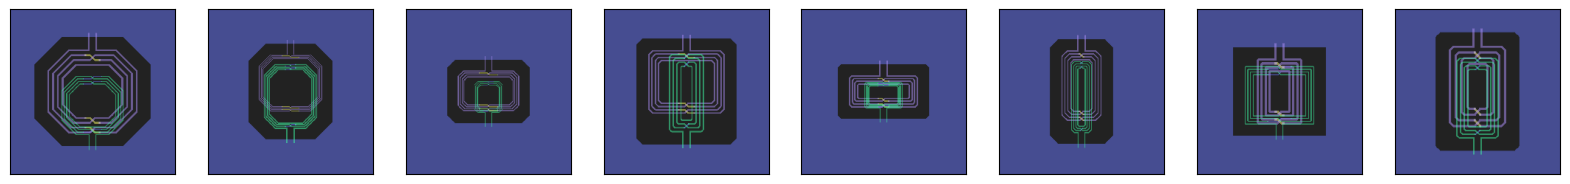

In [7]:
#load data
#geometrical parameters stored in log.txt
#order of geopara (radiusA,radiusB,turnsA,turnsB,openA,openB,outA,outB,extA,extB,ratio,outbound)
geoparas = []
images11 = []
labels11 = []
ind_a11 = []
ind_b11 = []
srf_list = []
for i in range(4):
    for j in range(4):
        path = "/rdf/shared/design_automation/Data_EMX/XFMR_2503_"+str(i+1)+"x"+str(j+1)+"/"
        load_from_path(path)

### Unimodal Encoder Architectures

In [8]:
#Schematic (CNN)
class SchemEncoder(nn.Module):
    def __init__(self, fmax):
        super(SchemEncoder, self).__init__()
        
        # Define the CNN part for input 1 (224x224x3)
        self.cnn = nn.Sequential(
            nn.Conv2d(3, n_channel, kernel_size=3, stride=1, padding=1),  # (224, 224, 32)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (112, 112, 32)
            nn.Conv2d(n_channel, n_channel*2, kernel_size=3, stride=1, padding=1),  # (112, 112, 128)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (56, 56, 128)
            nn.Conv2d(n_channel*2, n_channel*4, kernel_size=3, stride=1, padding=1),  # (56, 56, 128)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (28, 28, 128)
            nn.Conv2d(n_channel*4, n_channel*4, kernel_size=3, stride=1, padding=1),  # (28, 28, 128)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (14, 14, 128)
            nn.Conv2d(n_channel*4, n_channel*4, kernel_size=3, stride=1, padding=1),  # (14, 14, 128)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (7, 7, 128)
            nn.Flatten(),  # Flatten to (7 * 7 * 128)
            nn.Linear(7 * 7 * n_channel*4, 512),  # Fully connected layer
            nn.ReLU(),
        )
        
        # Define the output layers
        self.fc = nn.Sequential(
            nn.Linear(512, fmax * 12),  # Concatenate with input 2 (12 features)
            nn.Tanh(),
        )
        self.reshape = nn.Unflatten(1, (fmax, 12))  # Reshape to (fmax, 12)

    def forward(self, x1):
        # Process input 1 through CNN
        x = self.cnn(x1)
        # Concatenate with input 2
        #x = torch.cat((x1, x2), dim=1)
        # Fully connected layer and reshape
        x = self.fc(x)
        x = self.reshape(x)
        return x


In [9]:
#Graph (Graph Transformer)

def get_activation(activation_str):
    """Map string to activation function."""
    if activation_str.lower() == "relu":
        return F.relu
    elif activation_str.lower() == "gelu":
        return F.gelu
    # Add more activations if needed
    else:
        raise ValueError(f"Unsupported activation: {activation_str}")

class GraphTransformerEncoderBlock(nn.Module):
    """
    One Transformer encoder block, matching the structure of:
      1) Multi-head self-attention (with dropout)
      2) Feed-forward network (two linear layers + activation + dropout)
      3) LayerNorm + residual connections
      4) Optional "pre-norm" (norm_first=True) vs "post-norm" (norm_first=False)
    """
    def __init__(
        self,
        hidden_size,
        num_attention_heads,
        intermediate_size,
        activation="relu", #check with houbo which activation is the best for GT block performance
        dropout_rate=0.0,
        attention_dropout_rate=0.0,
        use_bias=False,
        norm_first=True,
        norm_epsilon=1e-6,
        intermediate_dropout=0.0
    ):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_attention_heads = num_attention_heads
        self.intermediate_size = intermediate_size
        self.dropout_rate = dropout_rate
        self.attention_dropout_rate = attention_dropout_rate
        self.use_bias = use_bias
        self.norm_first = norm_first
        self.norm_epsilon = norm_epsilon
        self.intermediate_dropout = intermediate_dropout

        # ---- Self-Attention ----
        # nn.MultiheadAttention expects shape: [seq_len, batch_size, embed_dim]
        # bias = `use_bias` is not directly exposed in nn.MultiheadAttention;
        # PyTorch always learns a bias in the projection layers. If you want
        # to remove bias, you must create a custom multi-head attention layer.
        self.self_attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=num_attention_heads,
            dropout=attention_dropout_rate,
            batch_first=False,  # We'll reshape manually
            # PyTorch multi-head attention includes biases by default.
            # For a strictly "no-bias" version, you'd need a custom approach.
        )

        self.attention_dropout = nn.Dropout(dropout_rate)
        self.attention_layer_norm = nn.LayerNorm(hidden_size, eps=norm_epsilon)

        # ---- Feed-Forward Network (FFN) ----
        self.intermediate_dense = nn.Linear(hidden_size, intermediate_size, bias=use_bias)
        self.intermediate_act_fn = get_activation(activation)
        self.intermediate_dropout_layer = nn.Dropout(intermediate_dropout)

        self.output_dense = nn.Linear(intermediate_size, hidden_size, bias=use_bias)
        self.output_dropout = nn.Dropout(dropout_rate)
        self.output_layer_norm = nn.LayerNorm(hidden_size, eps=norm_epsilon)

    def forward(self, hidden_states, attention_mask=None):
        """
        Args:
          hidden_states: Tensor of shape [batch_size, seq_len, hidden_size].
          attention_mask: Optional tensor for attention, expected shape
              [batch_size, seq_len, seq_len] with 0 for valid positions and
              -inf (or large negative) for masked positions, or a boolean mask.
              This may need to be adapted depending on how you've constructed
              your mask. 
        Returns:
          hidden_states: Tensor of shape [batch_size, seq_len, hidden_size].
        """

        # --- Self-Attention block ---
        # If norm_first, we layer-norm before attention; otherwise after
        residual = hidden_states
        if self.norm_first:
            hidden_states = self.attention_layer_norm(hidden_states)

        # Reshape hidden_states from [batch, seq, dim] to [seq, batch, dim]
        hidden_states_t = hidden_states.transpose(0, 1)

        # Convert mask if needed: PyTorch expects shape [seq_len, seq_len] or 
        # [batch_size * num_heads, seq_len, seq_len]. 
        # A simple approach is to expand so shape [batch, 1, seq, seq].
        # Then internally PyTorch may broadcast it properly, or you
        # can pass `attn_mask=some_mask` that is [seq, seq]. 
        # Here is an example that transforms the user’s [batch, seq, seq] 
        # into a float mask with -inf in invalid positions:
        if attention_mask is not None:
            # Suppose attention_mask=1 for valid, 0 for invalid, or the other way around.
            # You may need to invert it, depending on how your mask is built.
            # Here we assume "1 = keep, 0 = mask out".
            attn_mask_pytorch = (1.0 - attention_mask) * -1e9
            #print(attn_mask_pytorch.size())
            # Expand dims if needed to [batch, 1, seq, seq], then flatten
            # heads.  Alternatively, you can let PyTorch broadcast the shape.
            # We’ll do a direct approach below:
            #attn_mask_pytorch = attn_mask_pytorch.unsqueeze(1)  # [batch, 1, seq, seq]
            #print(attn_mask_pytorch.size())
        else:
            attn_mask_pytorch = None

        # Apply multi-head attention:
        attn_output, _ = self.self_attention(
            hidden_states_t,   # query
            hidden_states_t,   # key
            hidden_states_t,   # value
            attn_mask=attn_mask_pytorch,
        )

        # Transpose back to [batch, seq, dim]
        attn_output = attn_output.transpose(0, 1)

        attn_output = self.attention_dropout(attn_output)
        # Residual connection
        hidden_states = residual + attn_output

        if not self.norm_first:
            hidden_states = self.attention_layer_norm(hidden_states)

        # --- Feed Forward block ---
        residual = hidden_states
        if self.norm_first:
            hidden_states = self.output_layer_norm(hidden_states)

        # Intermediate (expand) + activation
        hidden_states = self.intermediate_dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        hidden_states = self.intermediate_dropout_layer(hidden_states)

        # Project back to hidden_size
        hidden_states = self.output_dense(hidden_states)
        hidden_states = self.output_dropout(hidden_states)

        # Residual connection
        hidden_states = residual + hidden_states

        if not self.norm_first:
            hidden_states = self.output_layer_norm(hidden_states)

        return hidden_states


class GraphTransformerEncoder(nn.Module):
    """
    Stacks N TransformerEncoderBlock layers and applies a final layer norm
    (to match the original Keras code which has 'output_normalization').
    """
    def __init__(
        self,
        num_layers=6,
        num_attention_heads=8,
        intermediate_size=2048,
        activation="relu",
        dropout_rate=0.0,
        attention_dropout_rate=0.0,
        use_bias=False,
        norm_first=True,
        norm_epsilon=1e-6,
        intermediate_dropout=0.0,
        hidden_size=None,
    ):
        """
        Args:
          num_layers: Number of encoder layers.
          num_attention_heads: Number of attention heads.
          intermediate_size: Dim of the FFN's hidden layer.
          activation: Activation for the intermediate (FFN) layer.
          dropout_rate: Dropout probability for the output of each sub-layer.
          attention_dropout_rate: Dropout probability for the attention scores.
          use_bias: Whether linear layers use bias.
          norm_first: If True, apply layer norm before each sub-block.
          norm_epsilon: Epsilon for layer norm.
          intermediate_dropout: Dropout within the feed-forward 'intermediate' layers.
          hidden_size: The input/output hidden size. If None, derive from input.
        """
        super().__init__()
        self.num_layers = num_layers
        self.num_attention_heads = num_attention_heads
        self.intermediate_size = intermediate_size
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.attention_dropout_rate = attention_dropout_rate
        self.use_bias = use_bias
        self.norm_first = norm_first
        self.norm_epsilon = norm_epsilon
        self.intermediate_dropout = intermediate_dropout

        # You can either require hidden_size to be passed explicitly,
        # or you can infer it at runtime (by passing the first batch through).
        if hidden_size is None:
            raise ValueError(
                "You must specify 'hidden_size' (the input feature dimension)."
            )

        self.encoder_layers = nn.ModuleList([
            GraphTransformerEncoderBlock(
                hidden_size=hidden_size,
                num_attention_heads=self.num_attention_heads,
                intermediate_size=self.intermediate_size,
                activation=self.activation,
                dropout_rate=self.dropout_rate,
                attention_dropout_rate=self.attention_dropout_rate,
                use_bias=self.use_bias,
                norm_first=self.norm_first,
                norm_epsilon=self.norm_epsilon,
                intermediate_dropout=self.intermediate_dropout,
            ) for _ in range(self.num_layers)
        ])

        self.output_normalization = nn.LayerNorm(hidden_size, eps=self.norm_epsilon)

    def forward(self, encoder_inputs, attention_mask=None):
        """
        Args:
          encoder_inputs: shape [batch_size, seq_len, hidden_size].
          attention_mask: shape [batch_size, seq_len, seq_len] or None.
        Returns:
          output shape [batch_size, seq_len, hidden_size].
        """
        hidden_states = encoder_inputs

        # Pass through each TransformerEncoderBlock
        for i, layer in enumerate(self.encoder_layers):
            #print(attention_mask.size())
            hidden_states = layer(hidden_states, attention_mask=attention_mask)

        # Final layer normalization (as in Keras code)
        output_tensor = self.output_normalization(hidden_states)
        return output_tensor


#################################
# Main Model
#################################
class GraphEncoder(nn.Module):
    def __init__(self, transformer_encoder, fmax):
        super(GraphEncoder, self).__init__()
        self.transformer_encoder = transformer_encoder  # Use the pre-defined transformer model
        self.fcl1 = nn.Linear(7, fdim)
        self.fcl2 = nn.Linear(7, fdim)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(max_len*fdim*2, 512)  # Adjust input shape after concatenation 448*512
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 512)
        self.fc5 = nn.Linear(512, 512)
        self.out = nn.Linear(512, fmax * 12)
        self.reshape = lambda x: x.view(-1, fmax, 12)  # Equivalent to `Reshape((fmax,12))` in Keras
    def forward(self, inp1, inp2):
        l1 = self.fcl1(inp1)
        l2 = self.fcl2(inp2)
        #print(l1.size())
        #print(create_padding_mask(l1).size())
        l1 = self.transformer_encoder(l1,create_padding_mask(inp1))
        l2 = self.transformer_encoder(l2,create_padding_mask(inp2))

        out = torch.cat((l1, l2), dim=1)  # Equivalent to `Concatenate()([l1, l2])`
        out = self.flatten(out) #shape [8 2048]
     #   print("1:", out.shape)  
        out = torch.relu(self.fc1(out))
        out = torch.relu(self.fc2(out))
        out = torch.relu(self.fc3(out))
        out = torch.relu(self.fc4(out))
        out = torch.relu(self.fc5(out))
      #  print("2:", out.shape)  
        out = torch.tanh(self.out(out))  # Equivalent to `Dense(fmax*12, activation='tanh')`
        out = self.reshape(out)
       # print("3:", out.shape)  
        return out


In [10]:
#Tabular (MLP)
# PyTorch model equivalent to Keras Sequential model
class TabEncoder(nn.Module):
    def __init__(self, fband, input_size=16):
        super(TabEncoder, self).__init__()
        self.fband = fband
        self.fc1 = nn.Linear(input_size, 512)  # Equivalent to Dense(512) in Keras
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 512)
        self.out = nn.Linear(512, fband * 12)  # Output layer
        self.tanh = nn.Tanh()  # Equivalent to 'tanh' activation

    def forward(self, x):
        x = F.relu(self.fc1(x))  # First Dense layer with ReLU activation
        x = F.relu(self.fc2(x))  # Second Dense layer
        x = F.relu(self.fc3(x))  # Third Dense layer
        x = F.relu(self.fc4(x))  # Fourth Dense layer
        x = self.out(x)          # Output layer
        x = self.tanh(x)         # Tanh activation for output
        #x = x.view(-1, self.fband, 12)  # Reshape to (fband, 12)
        return x




In [11]:
#token expansion - 1x512 -> 4x128
class TokenExpander(nn.Module):
    def __init__(self, in_dim=512, token_dim=512, num_tokens=6):
        super(TokenExpander, self).__init__()
        self.num_tokens = num_tokens
        self.token_dim = token_dim

        # Learn a projection from input to token sequence
        self.token_proj = nn.Linear(in_dim, num_tokens * token_dim)

        # Optional: normalization and non-linearity
        self.norm = nn.LayerNorm(token_dim)
        self.act = nn.GELU()

    def forward(self, x):
        # x: (batch_size, in_dim)
        B = x.shape[0]

        # Project and reshape
        tokens = self.token_proj(x)             # (B, num_tokens * token_dim)
        tokens = tokens.view(B, self.num_tokens, self.token_dim)  # (B, num_tokens, token_dim)

        # Normalize and activate each token
        tokens = self.norm(tokens)
        tokens = self.act(tokens)

        return tokens  # ready for self-attention

### Full Multimodal Model

In [12]:
#Helper function to freeze parameters for unimodal heads (non-joint training scheme)

def freeze(model):
    for param in model.parameters():
        param.requires_grad = False

In [13]:
class MultimodalModel(nn.Module):
    def __init__(self, pretrained_paths=None, num_latents=4, dim=512):
        super(MultimodalModel, self).__init__()

        #unimodal heads
        self.v1 = SchemEncoder(fband)# for schematic
        self.v2 = GraphEncoder(GraphTransformerEncoder(intermediate_size=512,hidden_size=fdim), fmax=fband) # for graph
        self.v3 = TabEncoder(fband)# for tabular


        if pretrained_paths: #load pretrained weights
            if 'schem_weights' in pretrained_paths:
                self.v1.load_state_dict(torch.load(pretrained_paths['schem_weights']), strict =False)
            if 'graph_weights' in pretrained_paths:
                self.v2.load_state_dict(torch.load(pretrained_paths['graph_weights']), strict =False)
            if 'tab_weights' in pretrained_paths:
                self.v3.load_state_dict(torch.load(pretrained_paths['tab_weights']), strict =False)

        """
        discard unnecessary layers and save parameters
        """
        self.v1.fc = nn.Identity()
        self.v1.reshape = nn.Identity()

        self.v2.out = nn.Identity()
        self.v2.reshape = nn.Identity()
        
        self.v3.out = nn.Identity()
        self.v3.tanh = nn.Identity()

        """
        Freeze parameters (comment out for joint training scheme)
        """
        freeze(self.v1)
        freeze(self.v2)
        freeze(self.v3)


        self.v1_tokenize = TokenExpander()
        self.v2_tokenize = TokenExpander()
        self.v3_tokenize = TokenExpander()
        
        
        """
        Initialize auxillary unimodal transformers for fusion layers
        """
        #encoder_base = nn.TransformerEncoderLayer(d_model=128, nhead=4) #d_model must be multiple of nhead      ***changed from (512,8) to (128,4)***
        fusion_layers = 4
        
        # self.schem_aux = nn.TransformerEncoder(encoder_base, num_layers=fusion_layers)
        # self.graph_aux = nn.TransformerEncoder(encoder_base, num_layers=fusion_layers)
        # self.tab_aux = nn.TransformerEncoder(encoder_base, num_layers=fusion_layers)
        
        """
        Initialize Fusion Encoder and spectral head
        """
        encoder_layers = []
        for i in range(fusion_layers):

            # Vanilla Transformer Encoder (use for full fine tuning)
            
            encoder_layers.append(nn.TransformerEncoderLayer(d_model = 512, nhead = 8))

            # Frozen Transformer Encoder with AdaptFormer 
            #encoder_layers.append(AdaptFormer(num_latents=num_latents, dim=dim, schem_enc=self.schem_aux.blocks[i], graph_enc=self.graph_aux.blocks[i], tab_enc=self.tab_aux.blocks[i]))
             
        self.fusion_blocks = nn.Sequential(*encoder_layers)

        #add normalization of bottlenecks maybe?
        self.flatten = nn.Flatten(start_dim=1)

        
        # spectral head
        self.head = nn.Sequential(
            nn.LayerNorm(512),
            nn.Linear(512,512), #upward projection to d=512
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(512),
            nn.Linear(512, fmax*12)
        )
        self.reshape = lambda res: res.view(-1, fmax, 12)

    def forward_encoder(self,tokens):     
        # encoder forward pass
        for blk in self.fusion_blocks:
            fused = blk(tokens) #edit bottlenecklayer
        return fused
        
    def forward(self, x, y_1, y_2, z):
        #unimodal head outputs
        x = self.v1(x)
        y = self.v2(y_1,y_2)
        z = self.v3(z)

        x= self.v1_tokenize(x)
        y= self.v2_tokenize(y)
        z= self.v3_tokenize(z)

        tokens = torch.cat([x,y,z], dim =1)
        #fusion transformer encoders
        tokens = self.forward_encoder(tokens)

        x = tokens.mean(dim=1) #mean pooling
        
        #spectral head
        x = self.head(x)
        out = self.reshape(x)
        return out

### Training

In [14]:
#Graph Hyperparameters
import math

# Set hyperparameters
d_model = 32
num_heads = 8
dff = 256
num_layers = 2
max_seq_len = 32
height = 7
dropout_rate = 0.1

#################################
# Positional Encoding
#################################
class PositionalEncoding(nn.Module):
    def __init__(self, seq_len, d_model):
        super(PositionalEncoding, self).__init__()
        positions = torch.arange(seq_len).unsqueeze(1).float()  # [seq_len, 1]
        dims = torch.arange(d_model).unsqueeze(0).float()  # [1, d_model]

        angle_rates = 1 / torch.pow(10000.0, (2 * (dims // 2)) / d_model)
        angle_rads = positions * angle_rates

        # Compute sine and cosine
        sines = torch.sin(angle_rads[:, 0::2])
        cosines = torch.cos(angle_rads[:, 1::2])

        # Concatenate sine and cosine
        pos_encoding = torch.cat([sines, cosines], dim=-1)  # [seq_len, d_model]
        self.pos_encoding = pos_encoding.unsqueeze(0)  # [1, seq_len, d_model]

    def forward(self, x):
        return self.pos_encoding[:, :x.size(1), :].to(x.device)

#################################
# Padding Mask
#################################
def create_padding_mask(x):
    """
    Compute the padding mask:
    - x: [batch_size, seq_len, height]
    - mask: [batch_size, 1, 1, seq_len]
    """
    summed = torch.sum(torch.abs(x), dim=2)  # [batch_size, seq_len]
    mask = (summed == 0).float()  # 1.0 indicates padding
     # Expand mask to match MultiheadAttention expected shape
    mask = mask[:, None, None, :]  # Shape: [batch_size, 1, 1, seq_len]
    
    # Reshape to [batch_size * num_heads, seq_len, seq_len]
    batch_size, seq_len, height = x.shape
    mask = mask.expand(batch_size, num_heads, seq_len, seq_len)  # [batch_size, num_heads, seq_len, seq_len] 
    # Merge batch_size and num_heads into the first dimension
    mask = mask.reshape(batch_size * num_heads, seq_len, seq_len)
    return mask


#################################
# Example Usage
#################################
# Creating a batch of variable-length sequences with each element being a vector of length 'height'.
# For demonstration:
# Sequence 1: length=4
# Sequence 2: length=7
# Sequence 3: length=3
# We'll pad them to length=7.

def pad_sequence(seq_len, max_len=7):
    length = seq_len.shape[0]
    pad_len = max_len - length
    return torch.cat([seq_len, torch.zeros(pad_len, height)], dim=0)

max_len = max(len(seq) for seq in ind_b11)
max_len = int(max_len) 
print(max_len)

new_a = []
print(ind_a11[0])
for a in ind_a11:
    padded_a = pad_sequence(torch.tensor(a, dtype=torch.float32),max_len)
    new_a.append(padded_a.detach().numpy())
print(np.shape(new_a))
print(new_a[0])
#transformer_encoder.eval()  # Set to evaluation mode
#transformer_encoder = TransformerEncoder(num_layers, d_model, num_heads, dff, max_seq_len)
#output = transformer_encoder(torch.stack(new_a))
#print("Output shape:", output.shape)  # [batch_size, seq_len, d_model]
new_b = []
for b in ind_b11:
    padded_b = pad_sequence(torch.tensor(b, dtype=torch.float32),max_len)
    new_b.append(padded_b.detach().numpy())
print(np.shape(new_b))


32
[[-1.65000000e-01 -1.76000000e+00 -1.65000000e-01 -1.00500000e+00
   7.55000000e-01  3.00000000e+00  3.64412197e-02]
 [-1.65000000e-01 -1.00500000e+00 -6.81793939e-01 -1.00500000e+00
   5.16793939e-01  3.00000000e+00 -8.55213436e-02]
 [-6.81793939e-01 -1.00500000e+00 -9.55000000e-01 -6.81793939e-01
   4.23206463e-01  3.00000000e+00  3.14385696e-01]
 [-9.55000000e-01 -6.81793939e-01 -9.55000000e-01  6.81793939e-01
   1.36358788e+00  3.00000000e+00  2.31381307e-03]
 [-9.55000000e-01  6.81793939e-01 -6.81793939e-01  1.00500000e+00
   4.23206463e-01  3.00000000e+00 -3.27722800e-01]
 [-6.81793939e-01  1.00500000e+00 -2.85000000e-01  1.00500000e+00
   3.96793939e-01  3.00000000e+00  1.04325765e-01]
 [-2.85000000e-01  1.00500000e+00 -3.50000000e-02  1.00500000e+00
   2.50000000e-01  3.00000000e+00 -3.27559248e-02]
 [-3.50000000e-02  1.00500000e+00  3.50000000e-02  1.00500000e+00
   7.00000000e-02  3.00000000e+00  1.24166443e-02]]
(16000, 32, 7)
[[-1.65000007e-01 -1.75999999e+00 -1.65000007

In [15]:
class item:
  def __init__(self, image, geopara, a,b,label,srf):
    self.image = image
    self.geopara = geopara
    self.a = a
    self.b = b
    self.label = label
    self.srf = srf
data = []
for i in range(len(ind_a11)):
    data.append(item(images11[i],geoparas[i],new_a[i],new_b[i],labels11[i],srf_list[i]))

np.random.shuffle(data)

In [16]:
#define the split length for training, validation and test datasets
length = len(images11)
split1 = int(0.6*length)
split2 = int(0.8*length)
data_train = data[0:split1]
data_valid = data[split1:split2]
data_test = data[split2:]

In [17]:
#Separate the training, validation and test datasets 
train_images = []
train_labels = []
train_a = []
train_b = []
train_geoparas = []
train_srf = []

valid_images = []
valid_labels = []
valid_a = []
valid_b = []
valid_geoparas = []
valid_srf = []

test_images = []
test_labels = []
test_a = []
test_b = []
test_geoparas = []
test_srf = []

#The targeted frequency span up to fmax, with 1GHz step
s_max = np.zeros((fmax,12))
s_min = np.zeros((fmax,12))
srange = np.zeros((fmax,12))


for i in range(len(data_train)):
    train_images.append(data_train[i].image)
    train_geoparas.append(data_train[i].geopara)
    train_a.append(data_train[i].a)
    train_b.append(data_train[i].b)
    train_labels.append(data_train[i].label)
    train_srf.append(data_train[i].srf)
x_train_img = np.array(train_images) / 255
x_train_srf = np.array(train_srf)
x_train_a = np.array(train_a) 
x_train_b = np.array(train_b)
x_train_geopara = np.array(train_geoparas)
y_train_encoded = np.array(train_labels)[:,1:fmax+1,:]


for i in range(len(data_valid)):
    valid_images.append(data_valid[i].image)
    valid_geoparas.append(data_valid[i].geopara)
    valid_a.append(data_valid[i].a)
    valid_b.append(data_valid[i].b)
    valid_labels.append(data_valid[i].label)
    valid_srf.append(data_valid[i].srf)
x_valid_img = np.array(valid_images) / 255
x_valid_srf = np.array(valid_srf)
x_valid_a = np.array(valid_a) 
x_valid_b = np.array(valid_b)
x_valid_geopara = np.array(valid_geoparas)
y_valid_encoded = np.array(valid_labels)[:,1:fmax+1,:]


for i in range(len(data_test)):
    test_images.append(data_test[i].image)
    test_geoparas.append(data_test[i].geopara)
    test_a.append(data_test[i].a)
    test_b.append(data_test[i].b)
    test_labels.append(data_test[i].label)
    test_srf.append(data_test[i].srf)
x_test_img = np.array(test_images) / 255
x_test_srf = np.array(test_srf)
x_test_a = np.array(test_a) 
x_test_b = np.array(test_b)
x_test_geopara = np.array(test_geoparas)
y_test_encoded = np.array(test_labels)[:,1:fmax+1,:]

#normalize the s-parameters for each frequency point
for z in range(fmax):
    for i in range(12):
        s_max[z,i] = max(max(y_train_encoded[:,z,i]),max(y_valid_encoded[:,z,i]),max(y_test_encoded[:,z,i]))
        s_min[z,i] = min(min(y_train_encoded[:,z,i]),min(y_valid_encoded[:,z,i]),min(y_test_encoded[:,z,i]))
        srange[z,i] = s_max[z,i]-s_min[z,i]
    
    for i in range(12):
        y_train_encoded[:,z,i] = 2*(y_train_encoded[:,z,i]-s_min[z,i])/srange[z,i]-1

    for i in range(12):
        y_valid_encoded[:,z,i] = 2*(y_valid_encoded[:,z,i]-s_min[z,i])/srange[z,i]-1
    
    for i in range(12):
        y_test_encoded[:,z,i] = 2*(y_test_encoded[:,z,i]-s_min[z,i])/srange[z,i]-1

In [18]:
import torch.optim as optim
# Check if CUDA is available and set the device
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

learning_rate = 1e-4
epochs = 500

nband = int(1)
overlap = int(1)
fband = int(fmax *overlap/ nband)  # Replace with your value for fmax
bandslice = int(fband/overlap)
fdim = 32
#max_len = 7 #idk what this is yet
n_channel = 16

models_dir = '/home/ch106/Desktop/ASP_DAC2026/MxN/models'
pretrained_paths = { #dictionary storing pretrained weights for unimodal encoders
    'schem_weights': models_dir + '/' +'cnn_1band/0.pth',
    'graph_weights': models_dir + '/' +'GT_1band/0.pth',
    'tab_weights': models_dir + '/' +'mlp_1band/0.pth'
}

Using device: cuda:2


In [19]:
def custom_loss(y_true, y_pred):
    Lf = torch.sqrt(torch.mean((y_true - y_pred) ** 2, dim=1))  # Compute RMSE across feature axis
    return torch.log(torch.mean(Lf))  # Compute log of mean RMSE
    #return (torch.mean(Lf))

In [20]:
import time

In [21]:
#initialize model
model = MultimodalModel(pretrained_paths=pretrained_paths).to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
def lr_lambda(epoch):
    return 0.95 ** (epoch / 100)  # 对应 Keras 的 0.95**(epoch/20)

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.995)

# Loss function
loss_function = custom_loss

#initialize epoch start time


# Metric for MAE (Mean Absolute Error)
def mae(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))


# Training loop
def train_model(model, optimizer, scheduler,loss_function, num_epochs, dataloader):
    total_start_time = time.time()
    epoch_start_time = time.time() #initialize for first epoch
    for epoch in range(num_epochs):
        
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_mae = 0.0

        for batch in dataloader:
            inp0, inp1, inp2, inp3, y_true = batch  # Unpack inputs and true labels

            # Move data to GPU
            inp0 = inp0.to(device)
            inp1 = inp1.to(device)
            inp2 = inp2.to(device)
            inp3 = inp3.to(device)
            y_true = y_true.to(device)

            optimizer.zero_grad()  # Clear gradients
            y_pred = model(inp0,inp1,inp2,inp3)  # Forward pass
            
            assert y_pred.dtype == y_true.dtype, f"Dtype mismatch: {y_pred.dtype} vs {y_true.dtype}"
            
            # Compute loss
            loss = loss_function(y_true, y_pred)
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            # Metrics
            batch_mae = mae(y_true, y_pred)
            running_loss += loss.item()
            running_mae += batch_mae.item()
            torch.cuda.empty_cache()

        # Update learning rate at the end of each epoch
        scheduler.step()

        # Average loss and metrics for the epoch
        avg_loss = running_loss / len(dataloader)
        avg_mae = running_mae / len(dataloader)
        
        
        if epoch%20 == 0:
            epoch_time = time.time() - epoch_start_time
            epoch_start_time = time.time()
            
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, MAE: {avg_mae:.4f}, Time: {epoch_time:.2f}s")
    total_time = time.time() - total_start_time
    print(f"\nTotal training time: {total_time/60:.2f} minutes ({total_time:.2f} seconds)")
    
# Dummy data (replace with actual DataLoader)
batch_size = 32

xx = 0
# Convert data to PyTorch tensors and move them to float32
yout = torch.from_numpy(y_train_encoded[:, (xx * fband):(xx + 1) * fband]).type(torch.float32)
xa = torch.from_numpy(x_train_a).type(torch.float32)  # Example graph a input
xb = torch.from_numpy(x_train_b).type(torch.float32)  # Example graph b input
x1 = torch.from_numpy(x_train_img)  # Example image input
x1 = x1.permute(0, 3, 1, 2)
x2 = torch.from_numpy(x_train_geopara).type(torch.float32)  # Example geoparam input

dataset = torch.utils.data.TensorDataset(x1, xa, xb, x2, yout)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Move tensors to device
xa = xa.to(device)
xb = xb.to(device)
x1 = x1.to(device)
x2 = x2.to(device)
yout = yout.to(device)

# Train the model
print(f"GPU memory before: {torch.cuda.memory_allocated()/1024**3:.2f}GB")
#train_model(model, optimizer, scheduler, loss_function, epochs, dataloader)
print(f"GPU memory after: {torch.cuda.memory_allocated()/1024**3:.2f}GB")

GPU memory before: 0.00GB
GPU memory after: 0.00GB


In [22]:
torch.save(model.state_dict(), './weights/MMT_1band/'+str(xx) + '.pth')

In [23]:
torch.cuda.empty_cache()

In [24]:
# Frequency forward loop
def forward_loop():
    for ff in range(nband - overlap):
        xx = ff + 1
    #print(f"Processing dataset for frequency band {xx}")

    # Load model weights
        model.load_state_dict(torch.load('./weights/MMT_1band/'+str(xx - 1) + '.pth'))  # Load saved weights
        model.to(device)  # Ensure the model is on the correct device

    # Prepare new dataset for this iteration
        yout = torch.from_numpy(y_train_encoded[:, (xx * bandslice):(xx + overlap) * bandslice])
        yout = yout.type(torch.float32).to(device)  # Move data to the device
        dataset = torch.utils.data.TensorDataset(x1, xa, xb, x2, yout)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
    # Reinitialize optimizer and scheduler with the updated model parameters
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.995)

    # Train the model on the new dataset
        train_model(model, optimizer, scheduler, loss_function, epochs, dataloader)

    # Save the updated model weights
        torch.save(model.state_dict(), './weights/MMT_1band/'+str(xx) + '.pth')

In [25]:
# Frequency backward loop
def backward_loop():
    for ff in range(nband - overlap):
        xx = nband - ff - 1 - overlap
        #print(f"Processing dataset for frequency band {xx}")

    # Load model weights
        model.load_state_dict(torch.load('./weights/MMT_1band/'+str(xx + 1) + '.pth'))  # Load saved weights
        model.to(device)  # Ensure the model is on the correct device

    # Prepare new dataset for this iteration
        yout = torch.from_numpy(y_train_encoded[:, (xx * bandslice):(xx + overlap) * bandslice])
        yout = yout.type(torch.float32).to(device)  # Move data to the device
        dataset = torch.utils.data.TensorDataset(x1, xa, xb, x2, yout)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Reinitialize optimizer and scheduler with the updated model parameters
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.995)

    # Train the model on the new dataset
        train_model(model, optimizer, scheduler, loss_function, epochs, dataloader)

    # Save the updated model weights
        torch.save(model.state_dict(), './weights/MMT_1band/'+str(xx) + '.pth')


In [26]:
def prediction(ax):
    batch_size = 32  # you can adjust this based on your GPU headroom

    # prepare output arrays
    test_prediction_raw = np.zeros((len(x_test_a), fmax * overlap, 12))
    test_prediction     = np.zeros((len(x_test_a), fmax, 12))

    # graph test data health check

    # loop over each band model
    for xx in range(nband + 1 - overlap):
        # load weights and switch to eval
        model.load_state_dict(torch.load(f'./weights/MMT_1band/{xx}.pth'))
        model.eval()

        # batched inference for this band
        band_preds = []
        with torch.no_grad():
            for i in range(0, len(x_test_a), batch_size):
                # slice numpy → torch.cuda tensors
                a_batch     = torch.from_numpy(x_test_a[i:i+batch_size]).float().to(device)
                b_batch     = torch.from_numpy(x_test_b[i:i+batch_size]).float().to(device)
                schem_batch = (
                    torch.from_numpy(x_test_img[i:i+batch_size])
                         .float()
                         .permute(0, 3, 1, 2)
                         .to(device)
                )
                tab_batch   = torch.from_numpy(x_test_geopara[i:i+batch_size]).float().to(device)

                # forward
                out_batch = model(schem_batch, a_batch, b_batch, tab_batch)
                band_preds.append(out_batch.cpu().numpy())

        # concatenate all minibatches and store
        band_preds = np.concatenate(band_preds, axis=0)
        test_prediction_raw[:, fband * xx : fband * (xx + 1), :] = band_preds

        # reset for next band
        mae_all = np.zeros((fmax, 12))

    # combine overlapping predictions exactly as before
    mae_mean = np.zeros(fmax)
    for xx in range(nband):
        print(xx)
        if xx < overlap:
            for yy in range(1 + xx):
                test_prediction[:, bandslice*xx:bandslice*(xx+1), :] += \
                    test_prediction_raw[:, fband*(xx-yy)+yy*bandslice : fband*(xx-yy)+(yy+1)*bandslice, :]
            test_prediction[:, bandslice*xx:bandslice*(xx+1), :] /= (1 + xx)

        elif (nband - xx) < overlap:
            for yy in range(2 + xx - nband):
                test_prediction[:, bandslice*xx:bandslice*(xx+1), :] += \
                    test_prediction_raw[:, fband*(xx+1-overlap-yy)+(overlap-1-yy)*bandslice 
                                             : fband*(xx+1-overlap-yy)+(overlap-yy)*bandslice, :]
            test_prediction[:, bandslice*xx:bandslice*(xx+1), :] /= (2 + xx - nband)

        else:
            for yy in range(overlap):
                test_prediction[:, bandslice*xx:bandslice*(xx+1), :] += \
                    test_prediction_raw[:, fband*(xx-yy)+yy*bandslice : fband*(xx-yy)+(yy+1)*bandslice, :]
            test_prediction[:, bandslice*xx:bandslice*(xx+1), :] /= overlap

    # compute MAE and plot
    for z in range(fmax):
        for i in range(12):
            mae_all[z, i] = (
                np.mean(
                    np.abs(test_prediction[:, z, i] - y_test_encoded[:, z, i])
                )
                * 0.5
                * srange[z, i]
            )
        mae_mean[z] = np.mean(mae_all[z, :])

    ax.plot(range(fmax), mae_mean)
    print(np.mean(mae_mean))
    print(R_squared(torch.from_numpy(y_test_encoded),
                    torch.from_numpy(test_prediction)))

    return np.mean(mae_mean)

    
def R_squared(y, y_pred):
    # Residual sum of squares
    residual = torch.sum((y - y_pred) ** 2)
    
    # Total sum of squares
    total = torch.sum((y - torch.mean(y)) ** 2)
    
    # Compute R-squared
    r2 = 1.0 - (residual / total)
    return r2

In [27]:
def prediction_srf(ax, batch_size=32):
    # Preallocate output arrays
    test_prediction_raw = np.zeros((len(x_test_a), fmax * overlap, 12))
    test_prediction     = np.zeros((len(x_test_a), fmax, 12))

    # Loop over each frequency band
    for xx in range(nband + 1 - overlap):
        # Load weights and switch to eval/inference
        model.load_state_dict(torch.load(f'./weights/MMT_1band/{xx}.pth'))
        model.eval()

        # Collect this band’s predictions in batches
        band_preds = []
        with torch.no_grad():
            for i in range(0, len(x_test_a), batch_size):
                # Slice and move each modality to device
                a_batch = (
                    torch.from_numpy(x_test_a[i : i + batch_size])
                         .float()
                         .to(device)
                )
                b_batch = (
                    torch.from_numpy(x_test_b[i : i + batch_size])
                         .float()
                         .to(device)
                )
                schem_batch = (
                    torch.from_numpy(x_test_img[i : i + batch_size])
                         .float()
                         .permute(0, 3, 1, 2)
                         .to(device)
                )
                tab_batch = (
                    torch.from_numpy(x_test_geopara[i : i + batch_size])
                         .float()
                         .to(device)
                )

                # Forward pass
                out_batch = model(schem_batch, a_batch, b_batch, tab_batch)
                band_preds.append(out_batch.cpu().numpy())

        # Concatenate and store for this band
        band_preds = np.concatenate(band_preds, axis=0)
        test_prediction_raw[:, fband * xx : fband * (xx + 1), :] = band_preds

        # (reset placeholder, as in original)
        mae_all = np.zeros((fmax, 12))

    # Combine overlapping band predictions exactly as before
    for xx in range(nband):
        print(xx)
        if xx < overlap:
            for yy in range(1 + xx):
                test_prediction[:, bandslice * xx : bandslice * (xx + 1), :] += (
                    test_prediction_raw[
                        :,
                        fband * (xx - yy) + yy * bandslice : fband * (xx - yy) + (yy + 1) * bandslice,
                        :
                    ]
                )
            test_prediction[:, bandslice * xx : bandslice * (xx + 1), :] /= (1 + xx)

        elif (nband - xx) < overlap:
            for yy in range(2 + xx - nband):
                test_prediction[:, bandslice * xx : bandslice * (xx + 1), :] += (
                    test_prediction_raw[
                        :,
                        fband * (xx + 1 - overlap - yy) + (overlap - 1 - yy) * bandslice
                          : fband * (xx + 1 - overlap - yy) + (overlap - yy) * bandslice,
                        :
                    ]
                )
            test_prediction[:, bandslice * xx : bandslice * (xx + 1), :] /= (2 + xx - nband)

        else:
            for yy in range(overlap):
                test_prediction[:, bandslice * xx : bandslice * (xx + 1), :] += (
                    test_prediction_raw[
                        :,
                        fband * (xx - yy) + yy * bandslice : fband * (xx - yy) + (yy + 1) * bandslice,
                        :
                    ]
                )
            test_prediction[:, bandslice * xx : bandslice * (xx + 1), :] /= overlap

    # Compute SRF-normalized MAE
    n_srf = 100
    srf_mae_all = np.zeros((n_srf, 12))
    srf_mae     = np.zeros(n_srf)
    for z in range(n_srf):
        for sample in range(len(x_test_a)):
            freq_temp = int(min(fmax-1, z * test_srf[sample] * 2 * 2 / n_srf))
            for i in range(12):
                srf_mae_all[z, i] += (
                    abs(test_prediction[sample, freq_temp, i] - y_test_encoded[sample, freq_temp, i])
                    * 0.5
                    * srange[freq_temp, i]
                )
        srf_mae_all[z] /= len(x_test_a)
        srf_mae[z] = np.mean(srf_mae_all[z])

    # Plot and report
    ax.plot((2 / n_srf) * np.ones(n_srf) * np.arange(n_srf), srf_mae)
    print(np.mean(srf_mae))
    print(R_squared(torch.from_numpy(y_test_encoded),
                    torch.from_numpy(test_prediction)))

    return np.mean(srf_mae)


0
0
0.23890168836110476
tensor(-0.0675, dtype=torch.float64)
0
0.23435623989923468
tensor(-0.0675, dtype=torch.float64)
1
0
0.23890168836110476
tensor(-0.0675, dtype=torch.float64)
0
0.23435623989923468
tensor(-0.0675, dtype=torch.float64)
2
0
0.23890168836110476
tensor(-0.0675, dtype=torch.float64)
0
0.23435623989923468
tensor(-0.0675, dtype=torch.float64)
3
0
0.23890168836110476
tensor(-0.0675, dtype=torch.float64)
0
0.23435623989923468
tensor(-0.0675, dtype=torch.float64)
4
0
0.23890168836110476
tensor(-0.0675, dtype=torch.float64)
0
0.23435623989923468
tensor(-0.0675, dtype=torch.float64)


Text(0, 0.5, 'Average S-parameter mae')

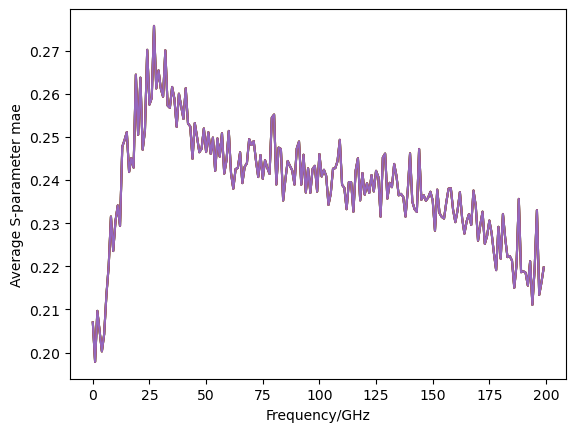

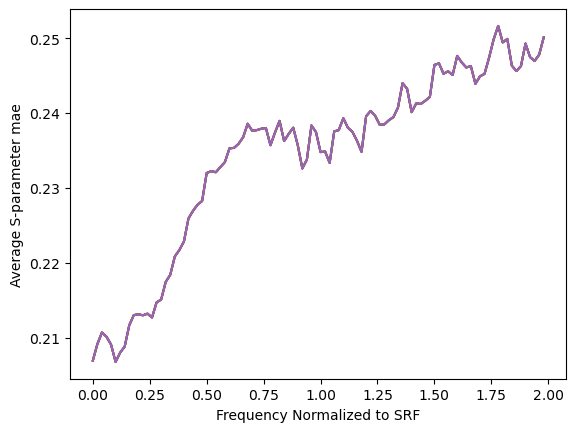

In [30]:
epochs = 200
iteration = 5
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
mae_trend = np.zeros(iteration)
for ii in range(iteration):
    epochs = epochs
    forward_loop()
    backward_loop()
    print(ii)
    mae_trend[ii]=prediction(ax1)
    prediction_srf(ax2)
ax1.set_xlabel('Frequency/GHz')
ax1.set_ylabel('Average S-parameter mae')
ax2.set_xlabel('Frequency Normalized to SRF')
ax2.set_ylabel('Average S-parameter mae')

In [29]:

print(x_test_img[0, :2, :2, 0])

[[0.27450982 0.27450982]
 [0.27450982 0.27450982]]
